In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import iqsq
from iqsq import (
    iq_cpu_naive,
    iq_cpu_opt_1,
    iq_gpu_naive,
    iq_gpu_opt_1,
    iq_gpu_opt_2,
    q_constants
)


In [2]:
scattering_factors_df = iqsq.build_scattering_factors_table(
    aff_elements_fp='GrSqf_cal_AP_Oct27/aff_elementonly.txt',
    aff_parameters_fp='GrSqf_cal_AP_Oct27/aff_parmonly.txt'
)
scattering_factors_df

,0,1,2,3,4,5,6,7,8
0,,,,,,,,,
H,0.489918,20.659300,0.262003,7.74039,0.196767,49.5519,0.049879,2.20159,0.001305
H1-,0.897661,53.136800,0.565616,15.18700,0.415815,186.5760,0.116973,3.56709,0.002389
He,0.873400,9.103700,0.630900,3.35680,0.311200,22.9276,0.178000,0.98210,0.006400
Li,1.128200,3.954600,0.750800,1.05240,0.617500,85.3905,0.465300,168.26100,0.037700
Li1+,0.696800,4.623700,0.788800,1.95570,0.341400,0.6316,0.156300,10.09530,0.016700
...,...,...,...,...,...,...,...,...,...
Pu6+,35.173600,0.473204,22.718100,2.73848,14.763500,11.5530,2.286780,20.93030,13.058200
Am,36.670600,0.483629,24.099200,3.20647,17.341500,14.3136,3.493310,102.27300,13.359200
Cm,36.648800,0.465154,24.409600,3.08997,17.399000,13.4346,4.216650,88.48340,13.288700


In [3]:
%load_ext line_profiler

In [4]:
atom_positions_df = iqsq.read_atom_positions(
    atom_positions_path="~/project/iq-on-gpu/data-20230605/5IrC_r5b.xyz",
    header=1,
    names=["x", "y", "z"],
    index_col=0,
    delim_whitespace=True
)
atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)

In [5]:
# runs for ~1.8 seconds on bmo
# atom_positions_df = iqsq.read_atom_positions(atom_positions_path="GrSqf_cal_AP_Oct27/Ni(OH)2-109391-ICSD-10x10x1.xyz")
# atom_distance_matrix_df = iqsq.build_atom_distance_matrix(atom_positions_df)
# %lprun -f iq_gpu_opt_1.calculate_iq \
#     iq_gpu_opt_1.calculate_iq( \
#         scattering_factors_df=sf_df, \
#         atom_distance_matrix_df=atom_distance_matrix_df, \
#         qmin=0.01, \
#         qmax=30, \
#         qstep=0.01 \
#     )

In [6]:
# in preparation for perturbing the atom positions
# find the minimum distance between atoms
atom_distance_matrix_df[atom_distance_matrix_df > 0].min()

Ir    1.994748
O     1.994748
O     1.994748
O     1.998288
O     1.998288
O     1.998415
O     2.000090
Ir    1.982764
O     1.982764
O     1.983547
O     1.998481
O     1.997455
Ir    1.983893
O     1.998288
O     1.998288
O     1.978655
Ir    1.986588
O     1.999155
O     1.999944
O     1.994748
O     1.995455
O     1.983893
Ir    1.978655
O     1.999036
O     1.999027
O     1.998288
O     1.999078
dtype: float64

In [7]:
atom_positions_df

,x,y,z
Ir,4.514,4.516,6.228
O,5.924,5.927,6.228
O,3.103,3.106,6.228
O,3.648,5.382,7.807
O,5.380,3.650,7.807
O,3.595,5.415,4.698
O,5.414,3.596,4.697
Ir,4.505,4.505,3.159
O,5.907,5.907,3.171
O,3.103,3.103,3.216


In [8]:
# perturb the atom locations slightly to create a new set of atom positions
rng = np.random.default_rng()
perturbed_atom_positions_df = atom_positions_df + rng.normal(scale=0.1, size=atom_positions_df.shape)
perturbed_atom_distance_matrix_df = iqsq.build_atom_distance_matrix(perturbed_atom_positions_df)

In [9]:
qIq = iq_gpu_opt_2.calculate_iq(
    scattering_factors_df=scattering_factors_df,
    atom_distance_matrix_df=atom_distance_matrix_df,
    qmin=0.01,
    qmax=30,
    qstep=0.01
)

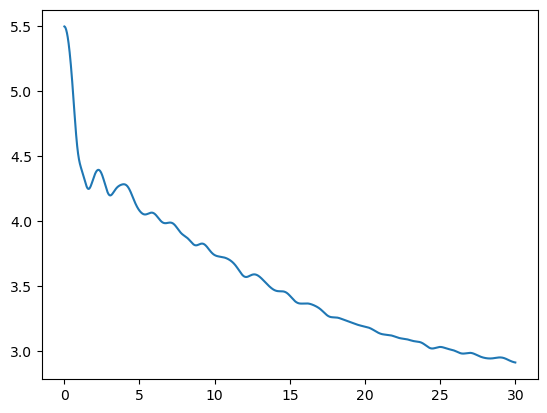

In [10]:
plt.plot(qIq[:,0],np.log10(qIq[:,1]))

In [11]:
perturbed_qIq = iq_gpu_opt_2.calculate_iq(
    scattering_factors_df=scattering_factors_df,
    atom_distance_matrix_df=perturbed_atom_distance_matrix_df,
    qmin=0.01,
    qmax=30,
    qstep=0.01
)

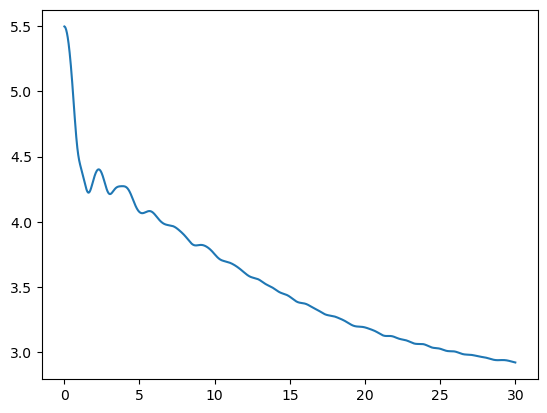

In [12]:
plt.plot(perturbed_qIq[:,0],np.log10(perturbed_qIq[:,1]))

In [13]:
experimental_qIq_df = pd.read_table(
    filepath_or_buffer="/home/jlynch/project/iq-on-gpu/data-20230605/A_0p303V-1_modified.chi",
    header=None
)

In [14]:
experimental_qIq_df

,0,1
0,0.80836,5295.62887
1,0.81976,5172.88821
2,0.83117,5064.56519
3,0.84257,4966.40648
4,0.85398,4875.16761
...,...,...
2863,33.46305,-520.31250
2864,33.47445,-510.43750
2865,33.48586,-499.18750
2866,33.49727,-494.31250


In [15]:
experimental_qIq = experimental_qIq_df.to_numpy()

In [16]:
experimental_qIq.shape

(2868, 2)

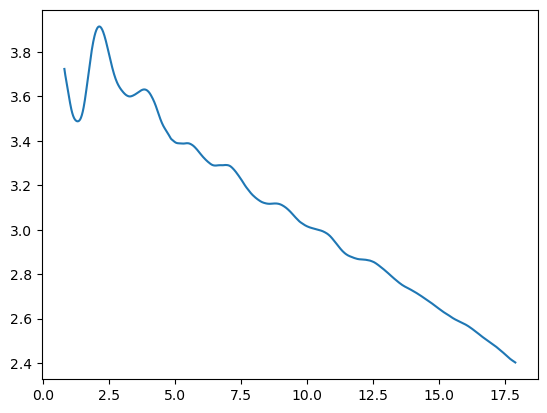

In [17]:
plt.plot(experimental_qIq[:1500,0],np.log10(experimental_qIq[:1500,1]))

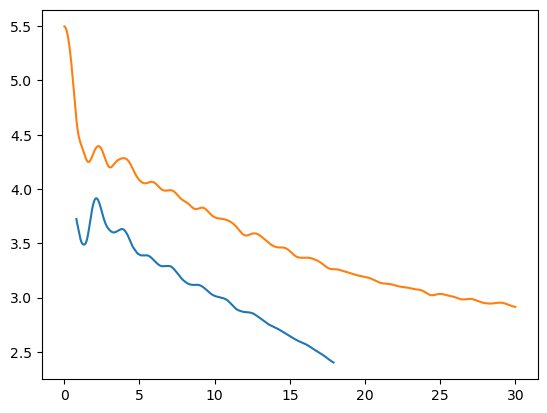

In [18]:
f = plt.figure()
ax = f.add_subplot(1, 1, 1)
ax.plot(experimental_qIq[:1500,0],np.log10(experimental_qIq[:1500,1]))
ax.plot(qIq[:,0],np.log10(qIq[:,1]))

In [26]:
np.mean(np.log10(qIq[:, 1]))

3.551508440972723

In [ ]:
use the experimental q values to calcualate I(q)
pick a range of q values
subtract the respective means
do theory and experiment line up better?

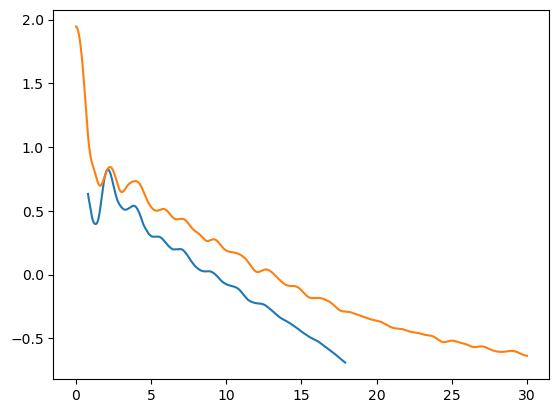

In [28]:
f = plt.figure()
ax = f.add_subplot(1, 1, 1)
ax.plot(experimental_qIq[:1500,0],np.log10(experimental_qIq[:1500,1])- np.mean(np.log10(experimental_qIq[:1500,1])))
ax.plot(qIq[:,0],np.log10(qIq[:,1]) - np.mean(np.log10(qIq[:,1])))

In [21]:
from scipy.spatial.distance import euclidean

perturbed_atom_positions = perturbed_atom_positions_df.to_numpy()

def Iq_cost(x, *args, return_qIq=False):
    _atom_positions_deltas = np.reshape(x, perturbed_atom_positions_df.shape)
    _atom_positions_df = perturbed_atom_positions_df + _atom_positions_deltas
    _atom_distance_matrix_df = iqsq.build_atom_distance_matrix(_atom_positions_df)
    _qIq = iq_gpu_opt_2.calculate_iq(
        scattering_factors_df=scattering_factors_df,
        atom_distance_matrix_df=_atom_distance_matrix_df,
        qmin=0.01,
        qmax=30,
        qstep=0.01
    )

    cost = euclidean(np.log(_qIq[:,1]), np.log(qIq[:,1]))
    #print(f"Iq_cost: {cost}")

    if return_qIq:
        return cost, _qIq
    else:
        return cost

In [22]:
def display_best_cost(xk, convergence):
    cost, qIq = Iq_cost(xk, return_qIq=True)
    # this is displayed when disp=True
    #print(f"best cost so far: {cost}")
    plt.plot(qIq[:,0],np.log10(qIq[:,1]))

In [23]:
from scipy.optimize import differential_evolution

parameter_count = atom_positions_df.shape[0] * atom_positions_df.shape[1]
print(f"parameter count: {parameter_count}")
de_result = differential_evolution(
    func=Iq_cost,
    bounds=[(-0.25, 0.25) for i in range(parameter_count)],
    popsize=2,
    polish=False,
    disp=True,
    callback=display_best_cost,
    maxiter=1000
)

parameter count: 81


KeyboardInterrupt: 

In [ ]:
de_result

In [ ]:
atom_positions = atom_positions_df.to_numpy()
de_position_offsets = np.reshape(de_result.x, atom_positions.shape)
de_atom_positions = perturbed_atom_positions + de_position_offsets

In [ ]:
plt.ion()

In [ ]:
def plot_Iq(_ax, _atom_distance_matrix_df):
    _qIq = iq_gpu_opt_2.calculate_iq(
        scattering_factors_df=scattering_factors_df,
        atom_distance_matrix_df=_atom_distance_matrix_df,
        qmin=0.01,
        qmax=30,
        qstep=0.01
    )

    _ax.plot(_qIq[:,0],np.log10(_qIq[:,1]))

    return _qIq

In [ ]:
perturbed_fig = plt.figure()
a3 = perturbed_fig.add_subplot(2, 2, 1, projection='3d')
a3.set_title("original and perturbed\npositions")
a3.scatter(
    perturbed_atom_positions[:, 0],
    perturbed_atom_positions[:, 1],
    perturbed_atom_positions[:, 2],
    color='r'
)
a3.scatter(
    atom_positions[:, 0],
    atom_positions[:, 1],
    atom_positions[:, 2],
    color='g'
)

ax_Iq = perturbed_fig.add_subplot(2, 2, 3)
perturbed_qIq = plot_Iq(ax_Iq, perturbed_atom_distance_matrix_df)
original_qIq = plot_Iq(ax_Iq, atom_distance_matrix_df)
ax_Iq.plot(perturbed_qIq[:, 0], np.log(perturbed_qIq[:, 1]) - np.log(original_qIq[:, 1]))

de_a3 = perturbed_fig.add_subplot(2, 2, 2, projection='3d')
de_a3.set_title("original and optimized\npositions")
de_a3.scatter(
    de_atom_positions[:, 0],
    de_atom_positions[:, 1],
    de_atom_positions[:, 2],
    color='b'
)
de_a3.scatter(
    atom_positions[:, 0],
    atom_positions[:, 1],
    atom_positions[:, 2],
    color='g'
)


de_ax_Iq = perturbed_fig.add_subplot(2, 2, 4)

de_atom_positions_df = perturbed_atom_positions_df + de_position_offsets
de_atom_distance_matrix_df = iqsq.build_atom_distance_matrix(de_atom_positions_df)

de_qIq = plot_Iq(de_ax_Iq, de_atom_distance_matrix_df)
original_qIq = plot_Iq(de_ax_Iq, atom_distance_matrix_df)
de_ax_Iq.plot(perturbed_qIq[:, 0], np.log(de_qIq[:, 1]) - np.log(original_qIq[:, 1]))
